# 1. data augmentation

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os

# Diretório contendo as imagens originais
original_dir = 'imagens'

# Diretório para salvar as imagens aumentadas
augmented_dir = 'imagens_aumentadas'

# Criar o diretório se não existir
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

# Configurar o ImageDataGenerator para aplicar as técnicas de data augmentation desejadas
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotacionar a imagem aleatoriamente no intervalo de -20 a 20 graus
    width_shift_range=0.1,  # Mover a imagem horizontalmente aleatoriamente em até 10% da largura
    height_shift_range=0.1, # Mover a imagem verticalmente aleatoriamente em até 10% da altura
    shear_range=0.2,        # Aplicar cisalhamento aleatório
    zoom_range=0.2,         # Aplicar zoom aleatório
    horizontal_flip=True,   # Virar horizontalmente aleatoriamente
    fill_mode='nearest'     # Preencher pixels gerados devido à rotação ou ao deslocamento
)

# Obter a lista de nomes de arquivos das imagens originais
original_image_files = os.listdir(original_dir)

# Para cada imagem original, gerar 5 imagens aumentadas
for filename in original_image_files:
    # Carregar a imagem original
    image_path = os.path.join(original_dir, filename)
    img = load_img(image_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)  # Reshape para que o gerador de imagem possa processar

    # Configurar um índice para o nome dos arquivos aumentados
    idx = 0

    # Gerar e salvar 5 imagens aumentadas
    for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_dir, save_prefix=filename[:-4]+'_aug_', save_format='jpg'):
        idx += 1
        if idx >= 5:  # Número desejado de imagens aumentadas por imagem original
            break


## Approach 1. Usar um modelo pre-treinado para encontrar por similaridade no banco

In [34]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity

# Função para carregar e pré-processar imagens
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Arquivo não encontrado: {image_path}")
    print("Carregando imagem:", image_path)  # Adicionando instrução de impressão
    
    # Carregar a imagem com Pillow
    with Image.open(image_path) as img:
        image = np.array(img)
    
    if image is None:
        raise ValueError(f"Erro ao ler a imagem: {image_path}")
    
    # Converter para RGB se necessário
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Redimensionar a imagem
    image = cv2.resize(image, target_size)
    
    # Pré-processamento final
    image = img_to_array(image)
    image = preprocess_input(image)
    
    return image



# Função para extrair características de uma imagem usando MobileNetV2
def extract_features(image_path, model):
    image = load_and_preprocess_image(image_path)
    features = model.predict(np.expand_dims(image, axis=0))
    return features.flatten()

# Carregar o modelo MobileNetV2 pré-treinado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Carregar imagens de pets e extrair características
pet_features = []
pet_files = []
for file in os.listdir('imagens'):
    if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
        file_path = os.path.join('imagens', file)
        pet_files.append(file)
        features = extract_features(file_path, base_model)
        pet_features.append(features)

# Convertendo a lista de características em matriz
pet_features = np.array(pet_features)

# Função para encontrar o pet mais semelhante
def find_most_similar_pet(image_path, pet_features, pet_files, base_model):
    query_features = extract_features(image_path, base_model)
    similarities = cosine_similarity([query_features], pet_features)
    most_similar_index = np.argmax(similarities)
    return pet_files[most_similar_index]

Carregando imagem: imagens\AABB São Leopoldo_Rua Cristopher Levalley, 774 - São Borja, São Leopoldo - RS, 93037-730_id_1101_aug__0_1282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Carregando imagem: imagens\AABB São Leopoldo_Rua Cristopher Levalley, 774 - São Borja, São Leopoldo - RS, 93037-730_id_1101_aug__0_2604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Carregando imagem: imagens\AABB São Leopoldo_Rua Cristopher Levalley, 774 - São Borja, São Leopoldo - RS, 93037-730_id_1101_aug__0_4111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Carregando imagem: imagens\AABB São Leopoldo_Rua Cristopher Levalley, 774 - São Borja, São Leopoldo - RS, 93037-730_id_1101_aug__0_6457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Carregando imagem: imagens\AABB São Leopoldo_Rua Cristopher Levalley, 774 - São Borja, São Leopoldo - RS, 93037-730_id_1101_aug__0_8961.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Carregando imagem: imagens\Animacão_R. Esmeralda, 500 - Imigrante Sul, Campo Bom - RS, 93700-000_id_1110_aug__0_

In [35]:
# Testar com uma imagem de exemplo
query_image_path = r'C:\Users\Pichau\Downloads\gato.jpg'
most_similar_pet = find_most_similar_pet(query_image_path, pet_features, pet_files, base_model)
print("O pet mais semelhante é:", most_similar_pet)

Carregando imagem: C:\Users\Pichau\Downloads\gato.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
O pet mais semelhante é: Centro Universitário Metodista - IPA_Rua Coronel Joaquim Pedro Salgado, 80 - Rio Branco, Porto Alegre - RS, 90420-060_id_1501_aug__0_3342.jpg


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.pyplot as plt

# Função para carregar e pré-processar imagens
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Arquivo não encontrado: {image_path}")
    print("Carregando imagem:", image_path)  # Adicionando instrução de impressão
    
    # Carregar a imagem com Pillow
    with Image.open(image_path) as img:
        image = np.array(img)
    
    if image is None:
        raise ValueError(f"Erro ao ler a imagem: {image_path}")
    
    # Converter para RGB se necessário
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Redimensionar a imagem
    image = cv2.resize(image, target_size)
    
    # Pré-processamento final
    image = img_to_array(image)
    image = preprocess_input(image)
    
    return image

# Função para extrair características de uma imagem usando MobileNetV2
def extract_features(image_path, model):
    image = load_and_preprocess_image(image_path)
    features = model.predict(np.expand_dims(image, axis=0))
    return features.flatten()

# Carregar o modelo MobileNetV2 pré-treinado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Carregar imagens de pets e extrair características
pet_features = []
pet_files = []
for file in os.listdir('imagens'):
    if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
        file_path = os.path.join('imagens', file)
        pet_files.append(file)
        features = extract_features(file_path, base_model)
        pet_features.append(features)

# Convertendo a lista de características em matriz
pet_features = np.array(pet_features)

# Função para encontrar o pet mais semelhante
def find_most_similar_pet(image_path, pet_features, pet_files, base_model):
    query_features = extract_features(image_path, base_model)
    similarities = cosine_similarity([query_features], pet_features)
    most_similar_indices = similarities.argsort()[0][-5:][::-1]
    return [pet_files[i] for i in most_similar_indices]

Carregando imagem: C:\Users\Pichau\Downloads\gato.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


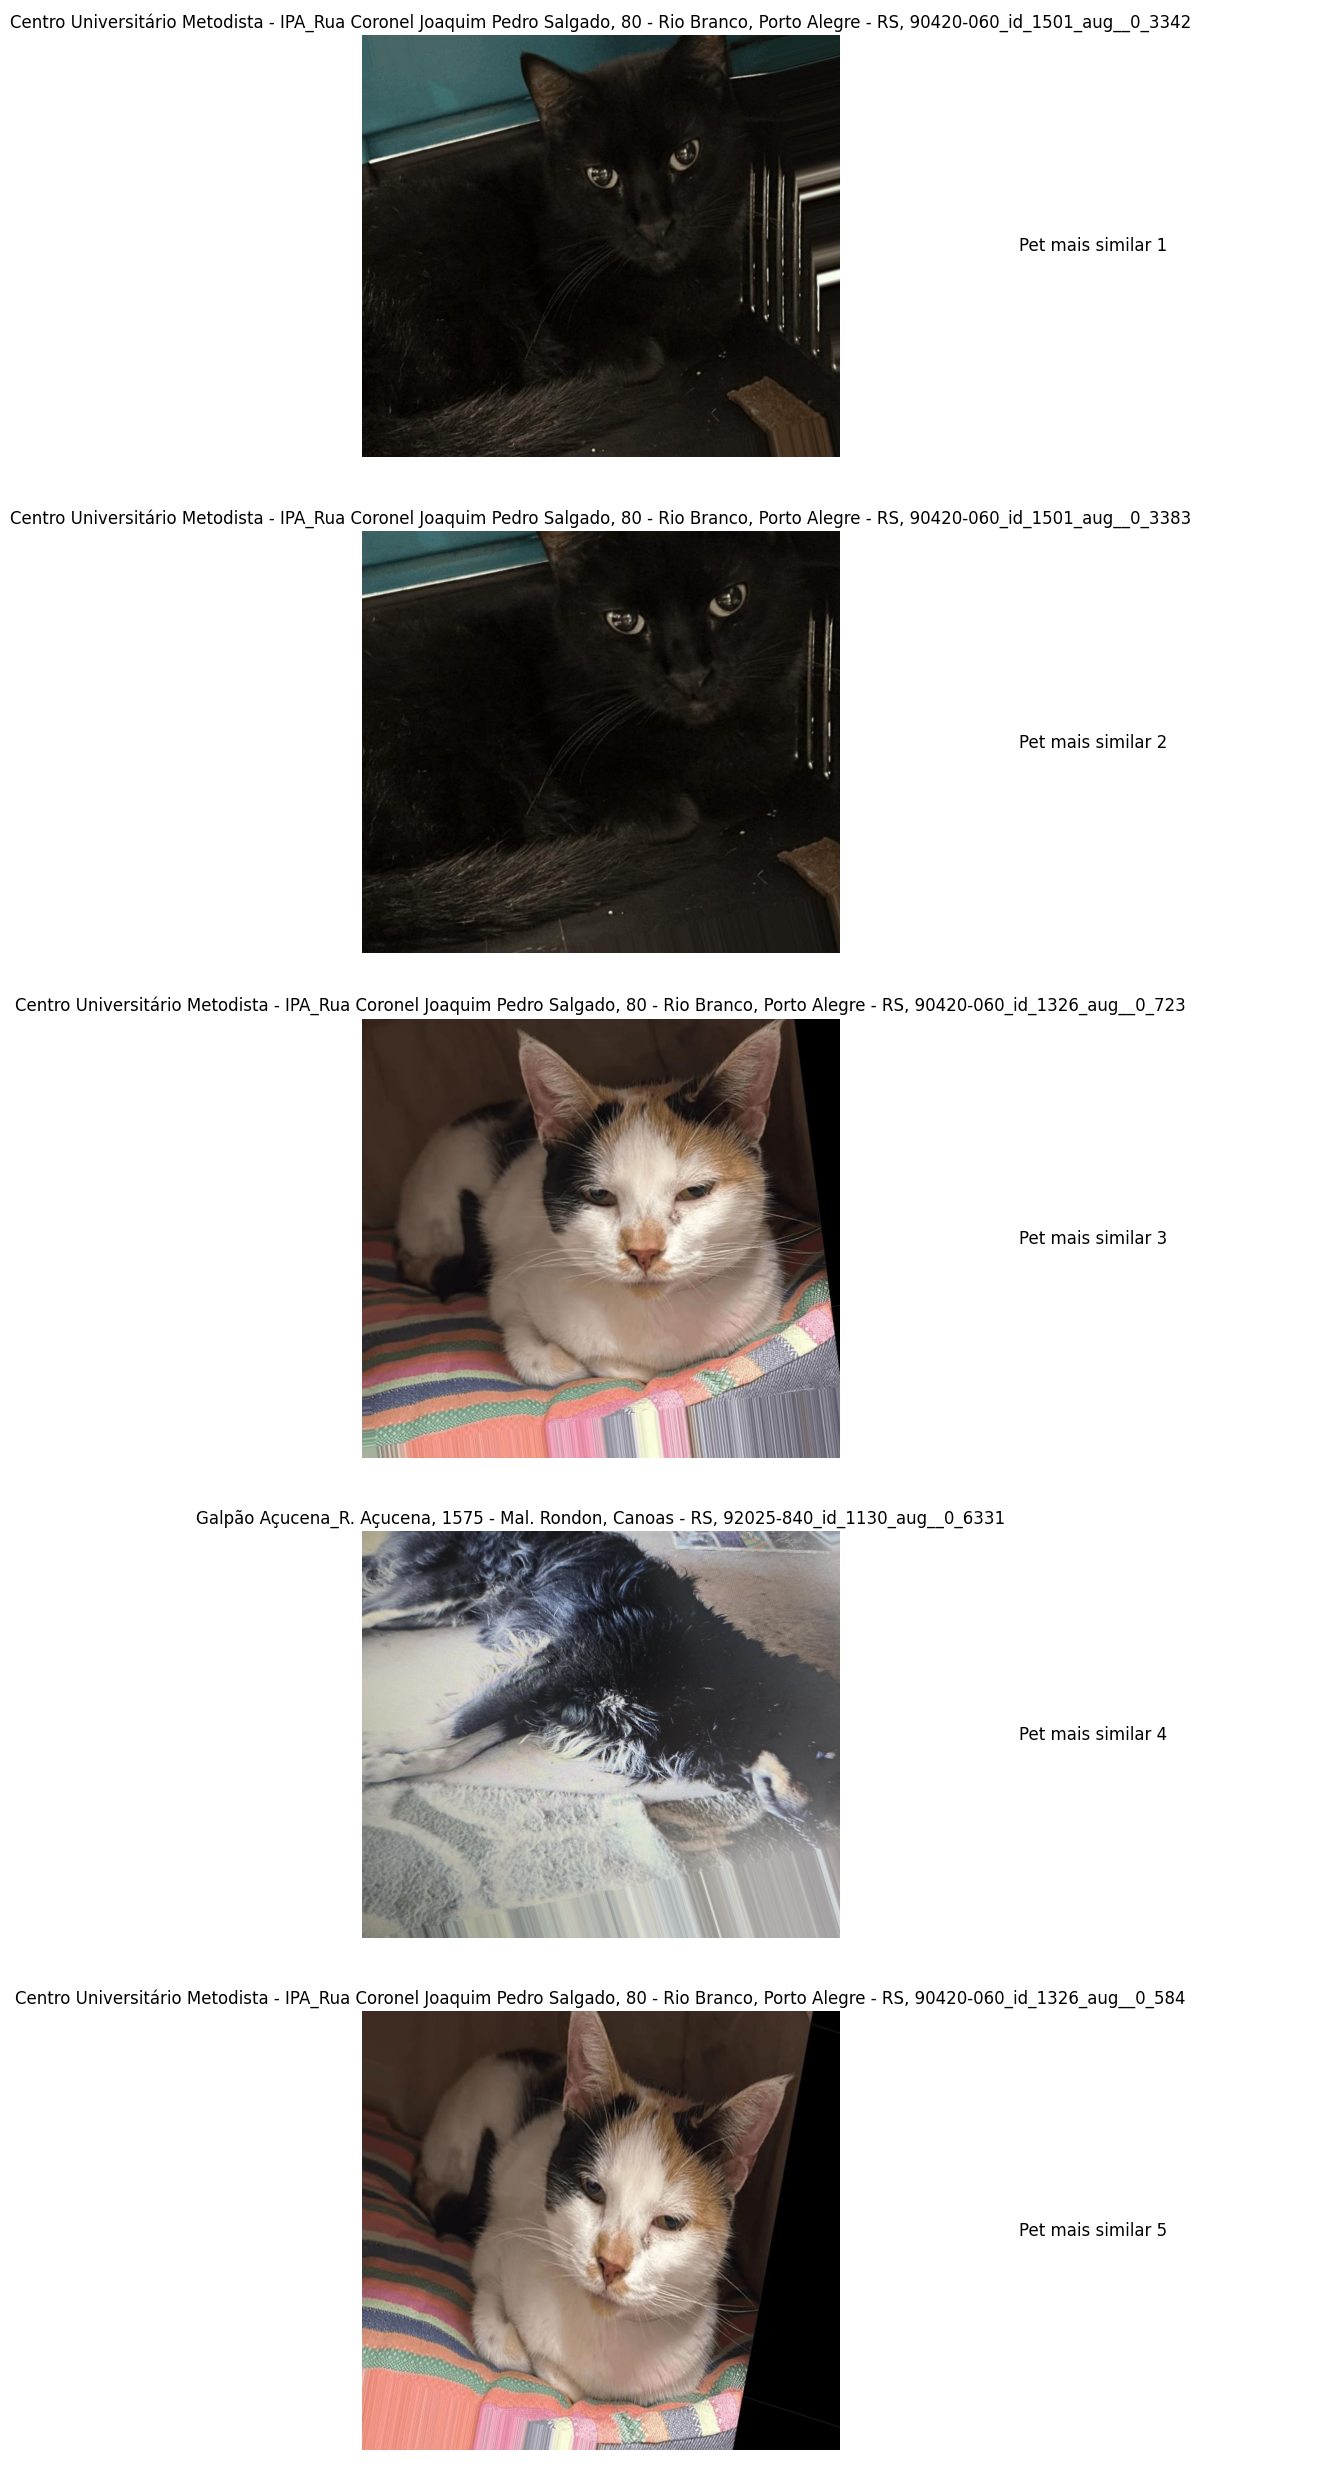

Os 5 pets mais similares são: ['Centro Universitário Metodista - IPA_Rua Coronel Joaquim Pedro Salgado, 80 - Rio Branco, Porto Alegre - RS, 90420-060_id_1501_aug__0_3342.jpg', 'Centro Universitário Metodista - IPA_Rua Coronel Joaquim Pedro Salgado, 80 - Rio Branco, Porto Alegre - RS, 90420-060_id_1501_aug__0_3383.jpg', 'Centro Universitário Metodista - IPA_Rua Coronel Joaquim Pedro Salgado, 80 - Rio Branco, Porto Alegre - RS, 90420-060_id_1326_aug__0_723.jpg', 'Galpão Açucena_R. Açucena, 1575 - Mal. Rondon, Canoas - RS, 92025-840_id_1130_aug__0_6331.jpg', 'Centro Universitário Metodista - IPA_Rua Coronel Joaquim Pedro Salgado, 80 - Rio Branco, Porto Alegre - RS, 90420-060_id_1326_aug__0_584.jpg']


In [40]:
query_image_path = r'C:\Users\Pichau\Downloads\gato.jpg'
most_similar_pets = find_most_similar_pet(query_image_path, pet_features, pet_files, base_model)

fig, axes = plt.subplots(len(most_similar_pets), 2, figsize=(10, 5*len(most_similar_pets)))

for i, pet_file in enumerate(most_similar_pets):
    pet_image = plt.imread(os.path.join('imagens', pet_file))
    axes[i, 0].imshow(pet_image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(pet_file[:-4])
    
    axes[i, 1].text(0.5, 0.5, f"Pet mais similar {i+1}", ha='center', va='center', fontsize=12)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

print("Os 5 pets mais similares são:", most_similar_pets)